In [ ]:
!gdown 1-seYCFEqnYZcigH42YabKK3NbB_FwdXf
!gdown 1YmZvmRZsjChHmKTkQpZxiHKfRc-jUdtP

Downloading...
From: https://drive.google.com/uc?id=1-seYCFEqnYZcigH42YabKK3NbB_FwdXf
To: /content/test_data.csv
100% 4.94M/4.94M [00:00<00:00, 22.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YmZvmRZsjChHmKTkQpZxiHKfRc-jUdtP
To: /content/training_data.csv
100% 19.5M/19.5M [00:00<00:00, 50.8MB/s]


# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [ ]:

import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import transformers

print("TensorFlow version:", tf.__version__)
print("Transformers version:", transformers.__version__)


TensorFlow version: 2.15.0
Transformers version: 4.31.0


In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [ ]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Read the training data
train_file_path = "training_data.csv"
train_data = pd.read_csv(train_file_path, dtype=str)

# Read the test data
test_file_path = "test_data.csv"
test_data = pd.read_csv(test_file_path, dtype=str)

# Function to perform preprocessing on text data
def preprocess_text(text):
    # Remove punctuation symbols and double white spaces
    text = ' '.join(text.split())  # Remove extra white spaces
    text = ''.join([char for char in text if char.isalnum() or char == ' '])  # Remove punctuation
    # Lemmatization
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    # Remove stop words
    filtered_text = ' '.join([word for word in lemmatized_text.split() if word.lower() not in spacy.lang.en.stop_words.STOP_WORDS])
    return filtered_text

# Apply preprocessing to training data
train_data['clean_text'] = train_data['text'].apply(preprocess_text)

# Filter out rows with categories other than '0' and '1' from training data
train_data = train_data[train_data['target'].isin(['0', '1'])]

# Split the filtered training data into features and target
x_train = train_data['clean_text'].to_numpy().reshape(-1)
y_train = train_data['target'].to_numpy().reshape(-1)

# Apply preprocessing to test data
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Split the test data into features and target
x_test = test_data['clean_text'].to_numpy().reshape(-1)
y_test = test_data['target'].to_numpy().reshape(-1)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Print the shape of the TF-IDF matrices
print("Shape of x_train_tfidf:", x_train_tfidf.shape)
print("Shape of x_test_tfidf:", x_test_tfidf.shape)
print(set(y_test))
print(set(y_train))


Shape of x_train_tfidf: (4166, 130635)
Shape of x_test_tfidf: (1160, 130635)
{'1', '0'}
{'1', '0'}


# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

In these histograms and stats, we can see that almost all texts contain $500$ or less words. Also, we can see that the average length is very different depending on the category.

Please, note that the tokenization process may split words into several parts, so lengths could increase (or decrease too). This is only an orientative result.

# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_train):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_train[index] = category_id

# Display dictionary
category_to_name

{0: '1', 1: '0'}

In [ ]:
# Split into train and test datasets
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=777) # random_state to reproduce results

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train_encoded = roberta_encode(X_train, tokenizer)
X_val_encoded = roberta_encode(X_val, tokenizer)
x_test_encoded = roberta_encode(x_test, tokenizer)


y_train = np.asarray(y_train, dtype='int32')
y_val = np.asarray(y_val, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')

        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
        print(input_word_ids)
        print(input_mask)
        print(input_type_ids)

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME,trainable=True)
        x = roberta_model(input_word_ids, attention_mask=input_mask)
        print(x)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(1, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

        return model



In [ ]:
n_categories = 2  # Number of categories/classes

with strategy.scope():
    model = build_model(n_categories)
    model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_word_ids'), name='input_word_ids', description="created by layer 'input_word_ids'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_mask'), name='input_mask', description="created by layer 'input_mask'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.int32, name='input_type_ids'), name='input_type_ids', description="created by layer 'input_type_ids'")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 256, 768) dtype=float32 (created by layer 'tf_roberta_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_roberta_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 256)]                0         []                            
                                                     

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [ ]:
# Print shapes of input data and labels
print("Shape of X_train_encoded:", X_train_encoded['input_word_ids'].shape)
print("Shape of X_val_encoded:", X_val_encoded['input_word_ids'].shape)
print(f"Number of test samples: {X_test_encoded.shape[0]}")

print("Shape of y_train:", y_train.shape)

# Print a few samples of input data and labels
print("Sample of X_train_encoded:", X_train_encoded['input_word_ids'][0])
print("Sample of y_train:", y_train[0])

# Check for NaN or missing values
print("NaN values in X_train_encoded:", np.isnan(X_train_encoded['input_word_ids']).any())
print("NaN values in X_val_encoded:", np.isnan(X_val_encoded['input_word_ids']).any())
print("NaN values in y_train:", np.isnan(y_train).any())

# Check label encoding
print("Unique labels in y_train:", np.unique(y_train))


NameError: name 'X_train_encoded' is not defined

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train_encoded,
                        y_train,
                        epochs=5,
                        batch_size=16,
                        verbose=1,
                        validation_data=(X_val_encoded, y_val))

Training...
Epoch 1/5


235/235 [==============================] - 12790s 54s/step - loss: 2.8816 - accuracy: 0.6743 - val_loss: 1.8248 - val_accuracy: 0.6667
Epoch 2/5
100/235 [===========>..................] - ETA: 1:56:49 - loss: 1.3796 - accuracy: 0.6731

NameError: name 'history' is not defined

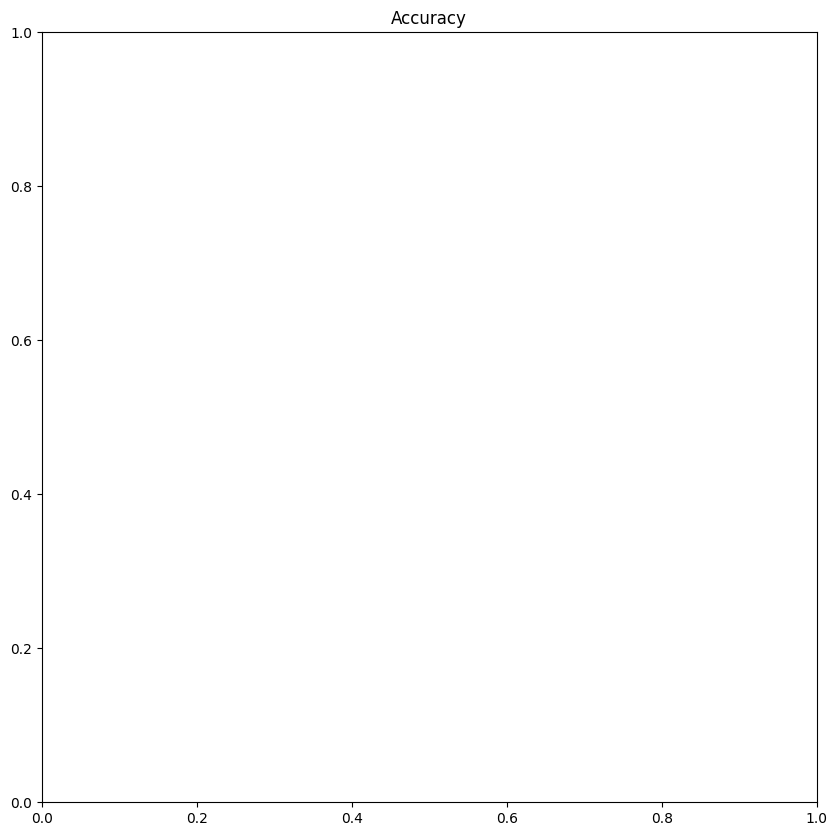

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

In [ ]:
plot_confusion_matrix(x_test, y_test, model)